In [1]:
!pip install unidecode
!pip install -q wordcloud
import wordcloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# import necessary libraries

import re
import random
import numpy as np
import pandas as pd
import unidecode
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word

In [3]:
# load data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TrumpTweets.csv")
print(df.shape)


(56571, 9)


In [4]:
# glimpse of raw dataset
pd.set_option('display.max_columns', None)
df.head(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f


In [5]:
# load only tweet ID and actual tweet into another dataframe
data = df[['id', 'text', 'date']]
print(data.shape)

(56571, 3)


In [6]:
# pre-processing data

# save hashtags in a separate column
data.loc[:,'hashtags']  = data.loc[:,'text'].apply(lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*', x))

# lower case
data.loc[:,'tweet'] = data.loc[:,'text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# remove links, mentions, emojis, special characters
data.loc[:,'tweet'] = data.loc[:,'tweet'].apply(lambda x: " ".join(re.sub("(&amp;)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(rt )|(\w+:\/\/\S+)"," ", x).split()))

# remove numbers
data.loc[:,'tweet'] = data.loc[:,'tweet'].apply(lambda x: " ".join([y for y in x.split() if not y == '/d*']))

# remove any symbols still left
data.loc[:,'tweet'] = data.loc[:,'tweet'].apply(lambda x: " ".join([unidecode.unidecode(y) for y in x.split()]))

# remove stop words
stop = stopwords.words('english')
data.loc[:,'tweet'] = data.loc[:,'tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# stemming
# st = PorterStemmer()
# data.loc[:,'tweet'] = data.loc[:,'tweet'].apply(lambda x: " ".join([st.stem(y) for y in x.split()]))

# lemmatization
data.loc[:,'tweet'] = data.loc[:,'tweet'].apply(lambda x: " ".join([Word(y).lemmatize() for y in x.split()]))


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [7]:
# tokenize tweets
data.loc[:,'token_tweet'] = data.loc[:,'tweet'].apply(nltk.word_tokenize)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [8]:
# check values of a tweet
pd.options.display.max_colwidth = 300
data.loc[data['id'] == 1326194143132082178]

,id,text,date,hashtags,tweet,token_tweet
189,1326194143132082178,"Republicans, don’t let Andrew McCabe continue to get away with totally criminal activity. What he did should never be allowed to happen to our Country again. FIGHT FOR JUSTICE!",2020-11-10 16:04:57,[],republican let andrew mccabe continue get away totally criminal activity never allowed happen country fight justice,"[republican, let, andrew, mccabe, continue, get, away, totally, criminal, activity, never, allowed, happen, country, fight, justice]"


In [9]:
# check 5 most used words from Trump's tweets
freq = pd.Series(' '.join(data['tweet']).split()).value_counts()[:5]
freq

great        7694
trump        7034
president    4856
amp          4415
thank        3622
dtype: int64

In [10]:
# word2vec model
model = Word2Vec(data['token_tweet'], min_count=10)

# words in model vocab
words = model.wv.vocab

In [11]:
# bag all words greater than 0.9 for hatred, divisive and racism
racism = model.wv.most_similar('racist', topn=len(model.wv.vocab))
hatred = model.wv.most_similar('hatred', topn=len(model.wv.vocab))
divisive = model.wv.most_similar('division', topn=len(model.wv.vocab))

racism_bag = [rw[0] for rw in racism if rw[1] > 0.9]
hatred_bag = [rw[0] for rw in hatred if rw[1] > 0.9]
divisive_bag = [rw[0] for rw in divisive if rw[1] > 0.9]

In [12]:
# get counts
while True:
  print(f'Vocabulary size - {len(model.wv.vocab)}')
  print(f'Racism bag size - {len(racism_bag)}')
  print(f'Hatred bag size - {len(hatred_bag)}')
  print(f'Division bag size - {len(divisive_bag)}')
  print(f'Common words in all the bags - {len(list(set(racism_bag) & set(hatred_bag) & set(divisive_bag)))}')
  break

Vocabulary size - 5406
Racism bag size - 89
Hatred bag size - 1031
Division bag size - 2067
Common words in all the bags - 52


In [13]:
# define a class to assign class to a tweet
def tweet_class(token_tweet):
  # print(len(token_tweet))
  # token = list(token_tweet)
  token = token_tweet
  if len(token) == 0:
    r_ct = 0
    h_ct = 0
    d_ct = 0
  else:
    r_ct = len(list(set(token) & set(racism_bag))) / len(token)
    h_ct = len(list(set(token) & set(hatred_bag))) / len(token)
    d_ct = len(list(set(token) & set(divisive_bag))) / len(token)

  if r_ct >= 0.06 and r_ct > h_ct and r_ct > d_ct:
    return 'racism'
  elif h_ct >= 0.06 and h_ct > r_ct and h_ct > d_ct:
    return 'hatred'
  elif d_ct >= 0.06 and d_ct > r_ct and d_ct > h_ct:
    return 'divisive'
  elif r_ct >= 0.06 and h_ct >= 0.06 and d_ct < 0.06:
    return random.choice(['racism', 'hatred'])
  elif h_ct >= 0.06 and d_ct >= 0.06 and r_ct < 0.06:
    return random.choice(['hatred', 'divisive'])
  elif d_ct >= 0.06 and r_ct >= 0.06 and h_ct < 0.06:
    return random.choice(['divisive', 'racism'])
  elif r_ct >= 0.06 and h_ct >= 0.06 and d_ct >= 0.06:
    return random.choice(['racism', 'hatred', 'divisive'])
  else:
    return 'none'

In [14]:
# classify tweets
data.loc[:,'tweet_class'] = data.loc[:,'token_tweet'].apply(lambda x: tweet_class(x))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [15]:
# check counts of classified tweet values
while True:
  print(f"Tweets classfied as none - {data[data.loc[:,'tweet_class'] == 'none'].shape[0]}")
  print(f"Tweets classfied as racism - {data[data.loc[:,'tweet_class'] == 'racism'].shape[0]}")
  print(f"Tweets classfied as hatred - {data[data.loc[:,'tweet_class'] == 'hatred'].shape[0]}")
  print(f"Tweets classfied as divisive - {data[data.loc[:,'tweet_class'] == 'divisive'].shape[0]}")
  print(f"Total Tweets - {data.loc[:,'tweet_class'].shape[0]}")
  break

Tweets classfied as none - 28462
Tweets classfied as racism - 722
Tweets classfied as hatred - 7263
Tweets classfied as divisive - 20124
Total Tweets - 56571


In [16]:
# convert date field to usuable format for plots
data.loc[:,'date'] = pd.to_datetime(data.loc[:,'date'], format = '%Y/%m/%d')

# add year and month fields
data.loc[:,'year'] = pd.DatetimeIndex(data.loc[:,'date']).year
data.loc[:,'month'] = pd.DatetimeIndex(data.loc[:,'date']).month

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [17]:
# glimpse of final dataset
pd.set_option('display.max_columns', None)
data.head(5)

,id,text,date,hashtags,tweet,token_tweet,tweet_class,year,month
0,98454970654916608,Republicans and Democrats have both created our economic problems.,2011-08-02 18:07:48,[],republican democrat created economic problem,"[republican, democrat, created, economic, problem]",none,2011,8
1,1234653427789070336,"I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y",2020-03-03 01:34:50,[#KAG2020],thrilled back great city charlotte north carolina thousand hardworking american patriot love country cherish value respect law always put america first thank wonderful evening kag2020,"[thrilled, back, great, city, charlotte, north, carolina, thousand, hardworking, american, patriot, love, country, cherish, value, respect, law, always, put, america, first, thank, wonderful, evening, kag2020]",none,2020,3
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance court obtained by CBS News questions where there will be further disciplinary action and cho…,2020-01-17 03:22:47,[],herridge read letter surveillance cou obtained cbs news question disciplinary action cho,"[herridge, read, letter, surveillance, cou, obtained, cbs, news, question, disciplinary, action, cho]",divisive,2020,1
3,1304875170860015617,"The Unsolicited Mail In Ballot Scam is a major threat to our Democracy, &amp; the Democrats know it. Almost all recent elections using this system, even though much smaller &amp; with far fewer Ballots to count, have ended up being a disaster. Large numbers of missing Ballots &amp; Fraud!",2020-09-12 20:10:58,[],unsolicited mail ballot scam major threat democracy democrat know almost recent election using system even though much smaller far fewer ballot count ended disaster large number missing ballot fraud,"[unsolicited, mail, ballot, scam, major, threat, democracy, democrat, know, almost, recent, election, using, system, even, though, much, smaller, far, fewer, ballot, count, ended, disaster, large, number, missing, ballot, fraud]",divisive,2020,9
4,1218159531554897920,RT @MZHemingway: Very friendly telling of events here about Comey's apparent leaking to compliant media. If you read those articles and tho…,2020-01-17 13:13:59,[],friendly telling event comey apparent leaking compliant medium read article tho,"[friendly, telling, event, comey, apparent, leaking, compliant, medium, read, article, tho]",hatred,2020,1


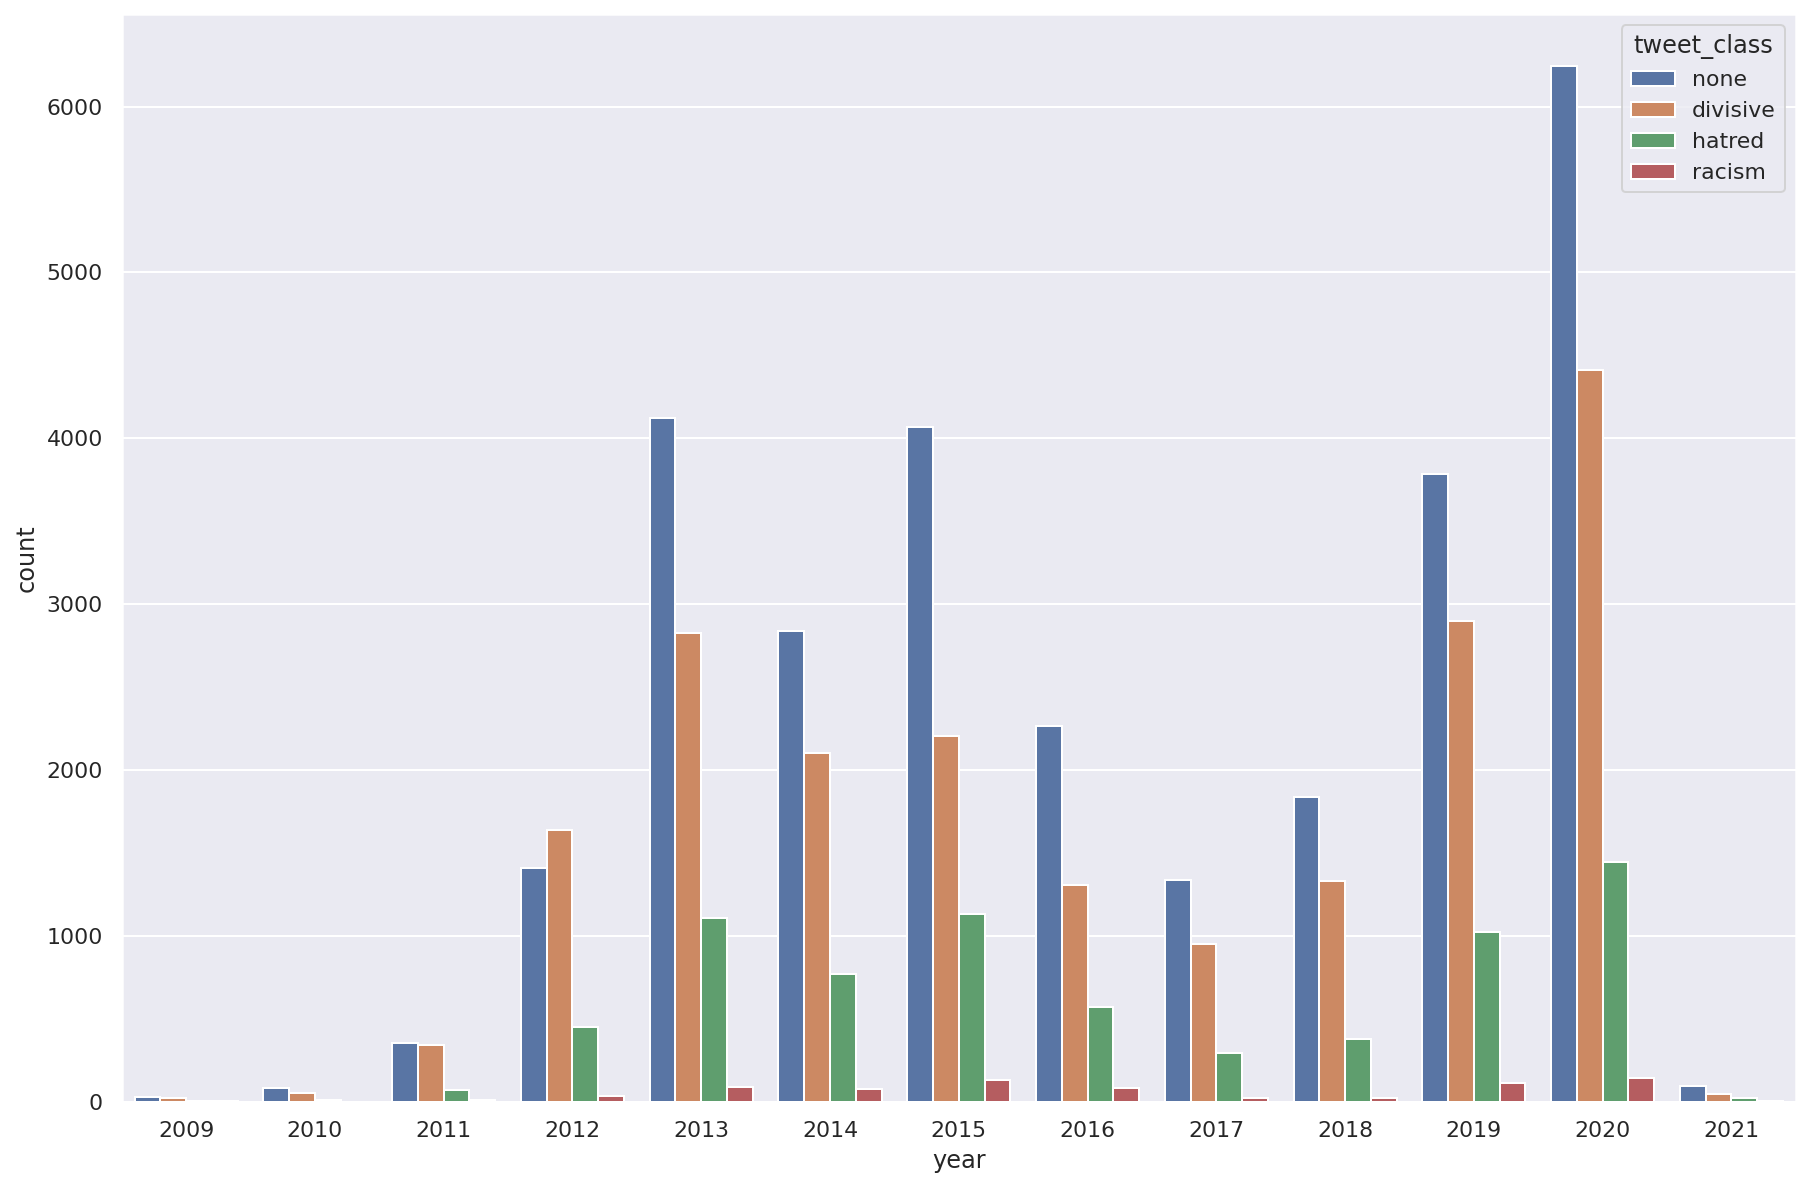

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

# classified tweets against year
sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme(style = 'darkgrid')
sns.countplot(data=data, x = 'year', hue = 'tweet_class')

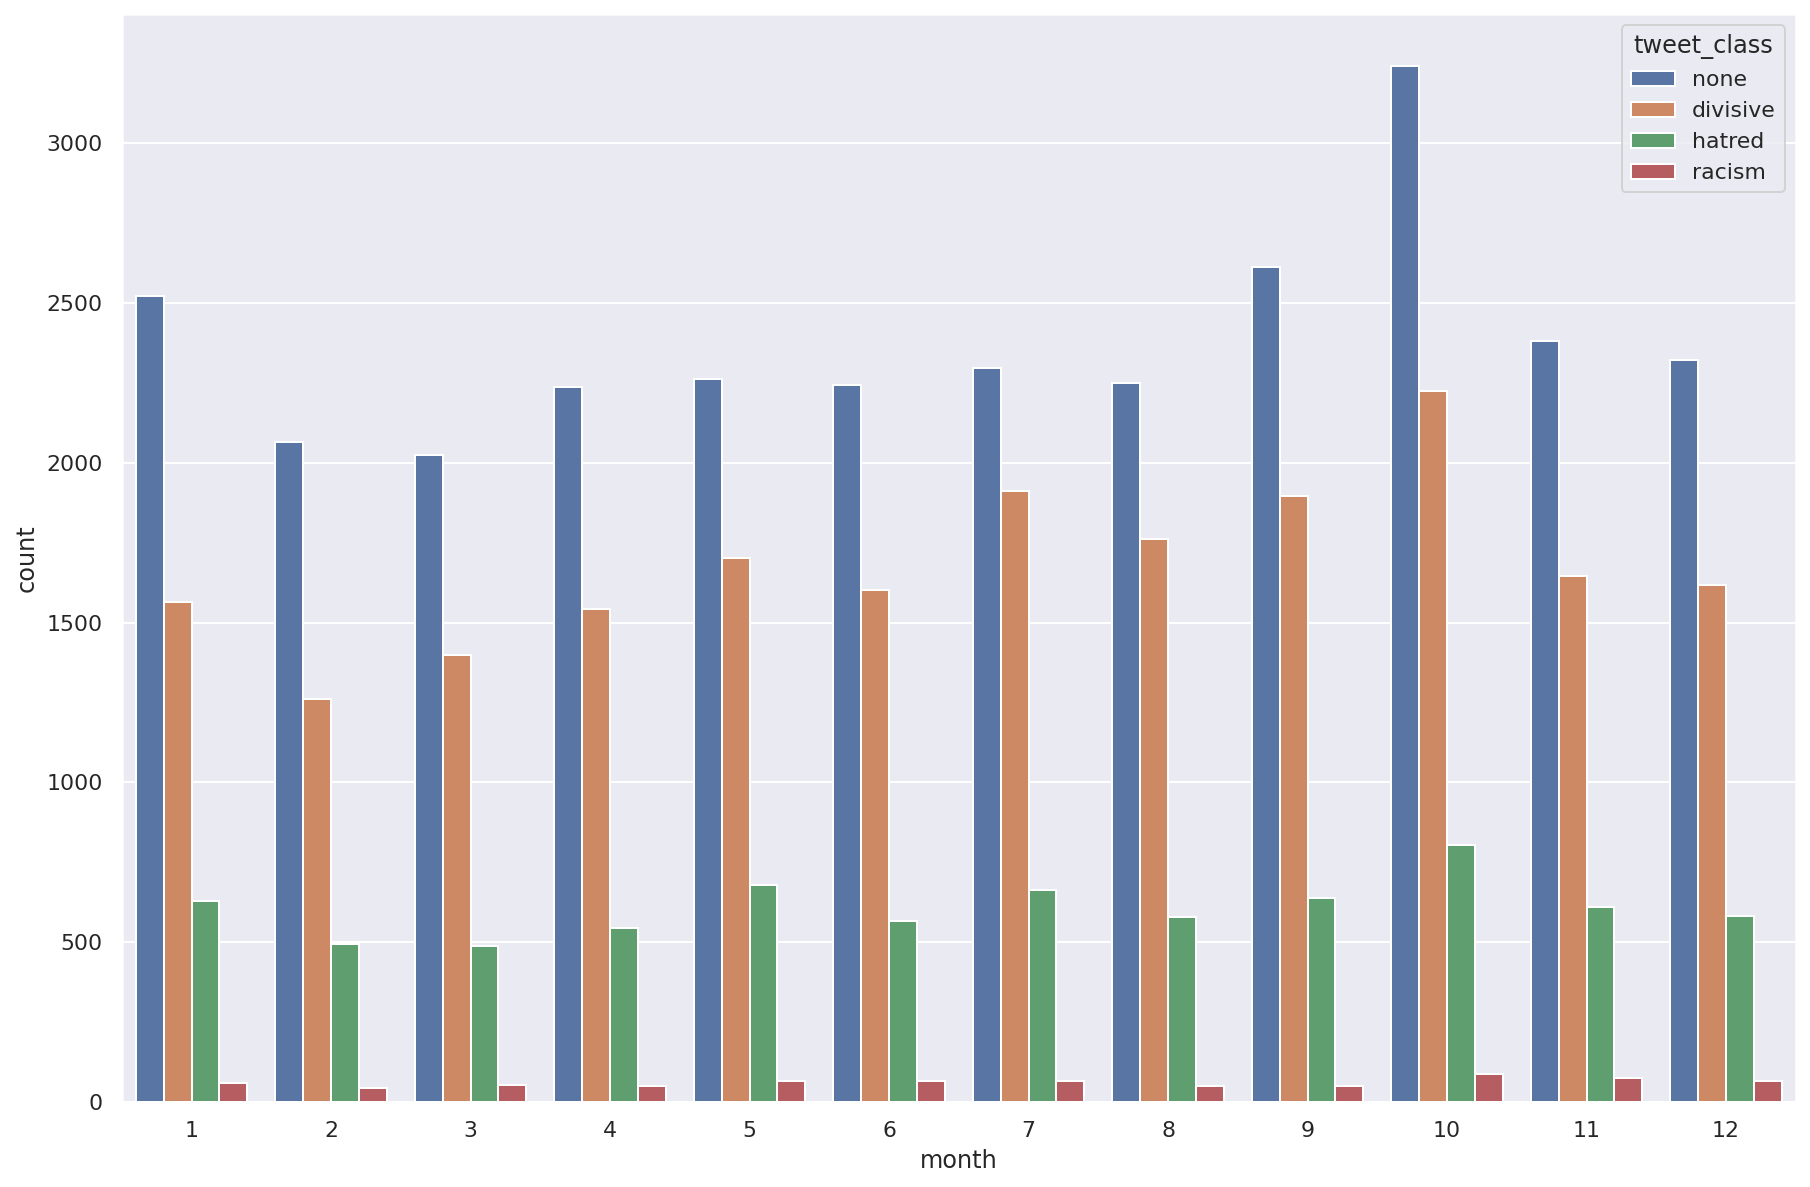

In [19]:
# classified tweets against year
sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme(style = 'darkgrid')
sns.countplot(data=data, x = 'month', hue = 'tweet_class')